## 두 가지 랜딩 페이지(구 'old_page', 신 'new_page')의 효과를 비교하기 위한 A/B검정 데이터
* [A/B testing - Kaggle](https://www.kaggle.com/zhangluyuan/ab-testing)

* 전환율(Conversion Rate)은 마케팅 및 웹 분석에서 사용하는 중요한 지표로, 특정 행동을 완료한 사용자의 비율을 의미합니다. 웹사이트를 방문한 100명의 사용자 중 5명이 제품을 구매했다면, 전환율은 5%가 됩니다. 
* 전환율은 마케팅 캠페인이나 웹사이트가 얼마나 효과적인지 보기 위한 지표입니다. 전환율은 방문자중에 원하는 행동 (예를들어 구매를 하거나 폼을 작성하는 등) 을 취한 사람의 비율로 계산됩니다. 
* 전환율은 세션 기반으로 산출되므로 실제보다 더 적은 비율처럼 보일 수 있습니다. 예를 들어 뉴스레터 구독 버튼이 1%의 전환율을 보인다면 실제 사용자 중 1%가 전환한 것이 아니라 전체 세션의 1%가 전환을 포함한다는 의미입니다


* 주요 변수
    * user_id: 웹사이트에 방문한 사용자의 고유 ID
    * timestamp: 사용자가 페이지에 방문한 시간
    * group: 사용자가 처리 그룹(treatment group)에 속하는지, 대조 그룹(control group)에 속하는지 여부
    * landing_page: 사용자가 구 페이지(old page)를 봤는지, 새 페이지(new page)를 봤는지 여부
    * converted: 사용자가 유료 사용자로 전환되었는지 여부. 1은 전환됨을 의미하며, 0은 전환되지 않았음을 의미합니다.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.stats.api as sms
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.family'] = 'Avenir'


In [2]:
df = pd.read_csv("~/aiffel/data/ab_data.csv")
df.shape

(294478, 5)

In [3]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
df.describe()

,user_id,converted
count,294478.000000,294478.000000
mean,787974.124733,0.119659
std,91210.823776,0.324563
min,630000.000000,0.000000
25%,709032.250000,0.000000
50%,787933.500000,0.000000
75%,866911.750000,0.000000
max,945999.000000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [6]:
df['datetime'] = pd.to_datetime(df['timestamp'])
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.time
df['dayofweek'] = df['datetime'].dt.dayofweek

In [7]:
df.groupby('dayofweek')['converted'].sum()

dayofweek
0    5589
1    5705
2    4831
3    4763
4    4699
5    4853
6    4797
Name: converted, dtype: int64

In [8]:
df.groupby('landing_page')['converted'].sum()

landing_page
new_page    17498
old_page    17739
Name: converted, dtype: int64

In [9]:
df.tail()

,user_id,timestamp,group,landing_page,converted,datetime,year,month,day,hour,minute,dayofweek
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0,2017-01-03 22:28:38.630509,2017,1,3,22,22:28:38.630509,1
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0,2017-01-12 00:51:57.078372,2017,1,12,0,00:51:57.078372,3
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0,2017-01-22 11:45:03.439544,2017,1,22,11,11:45:03.439544,6
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0,2017-01-15 01:20:28.957438,2017,1,15,1,01:20:28.957438,6
294477,715931,2017-01-16 12:40:24.467417,treatment,new_page,0,2017-01-16 12:40:24.467417,2017,1,16,12,12:40:24.467417,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       294478 non-null  int64         
 1   timestamp     294478 non-null  object        
 2   group         294478 non-null  object        
 3   landing_page  294478 non-null  object        
 4   converted     294478 non-null  int64         
 5   datetime      294478 non-null  datetime64[ns]
 6   year          294478 non-null  int32         
 7   month         294478 non-null  int32         
 8   day           294478 non-null  int32         
 9   hour          294478 non-null  int32         
 10  minute        294478 non-null  object        
 11  dayofweek     294478 non-null  int32         
dtypes: datetime64[ns](1), int32(5), int64(2), object(4)
memory usage: 21.3+ MB


In [11]:
# df["timestamp"] = pd.to_datetime(df["timestamp"])

# df["month"] = df["timestamp"].dt.month
# df["day"] = df["timestamp"].dt.day
# df["hour"] = df["timestamp"].dt.hour
# df["dayofweek"] = df["timestamp"].dt.dayofweek

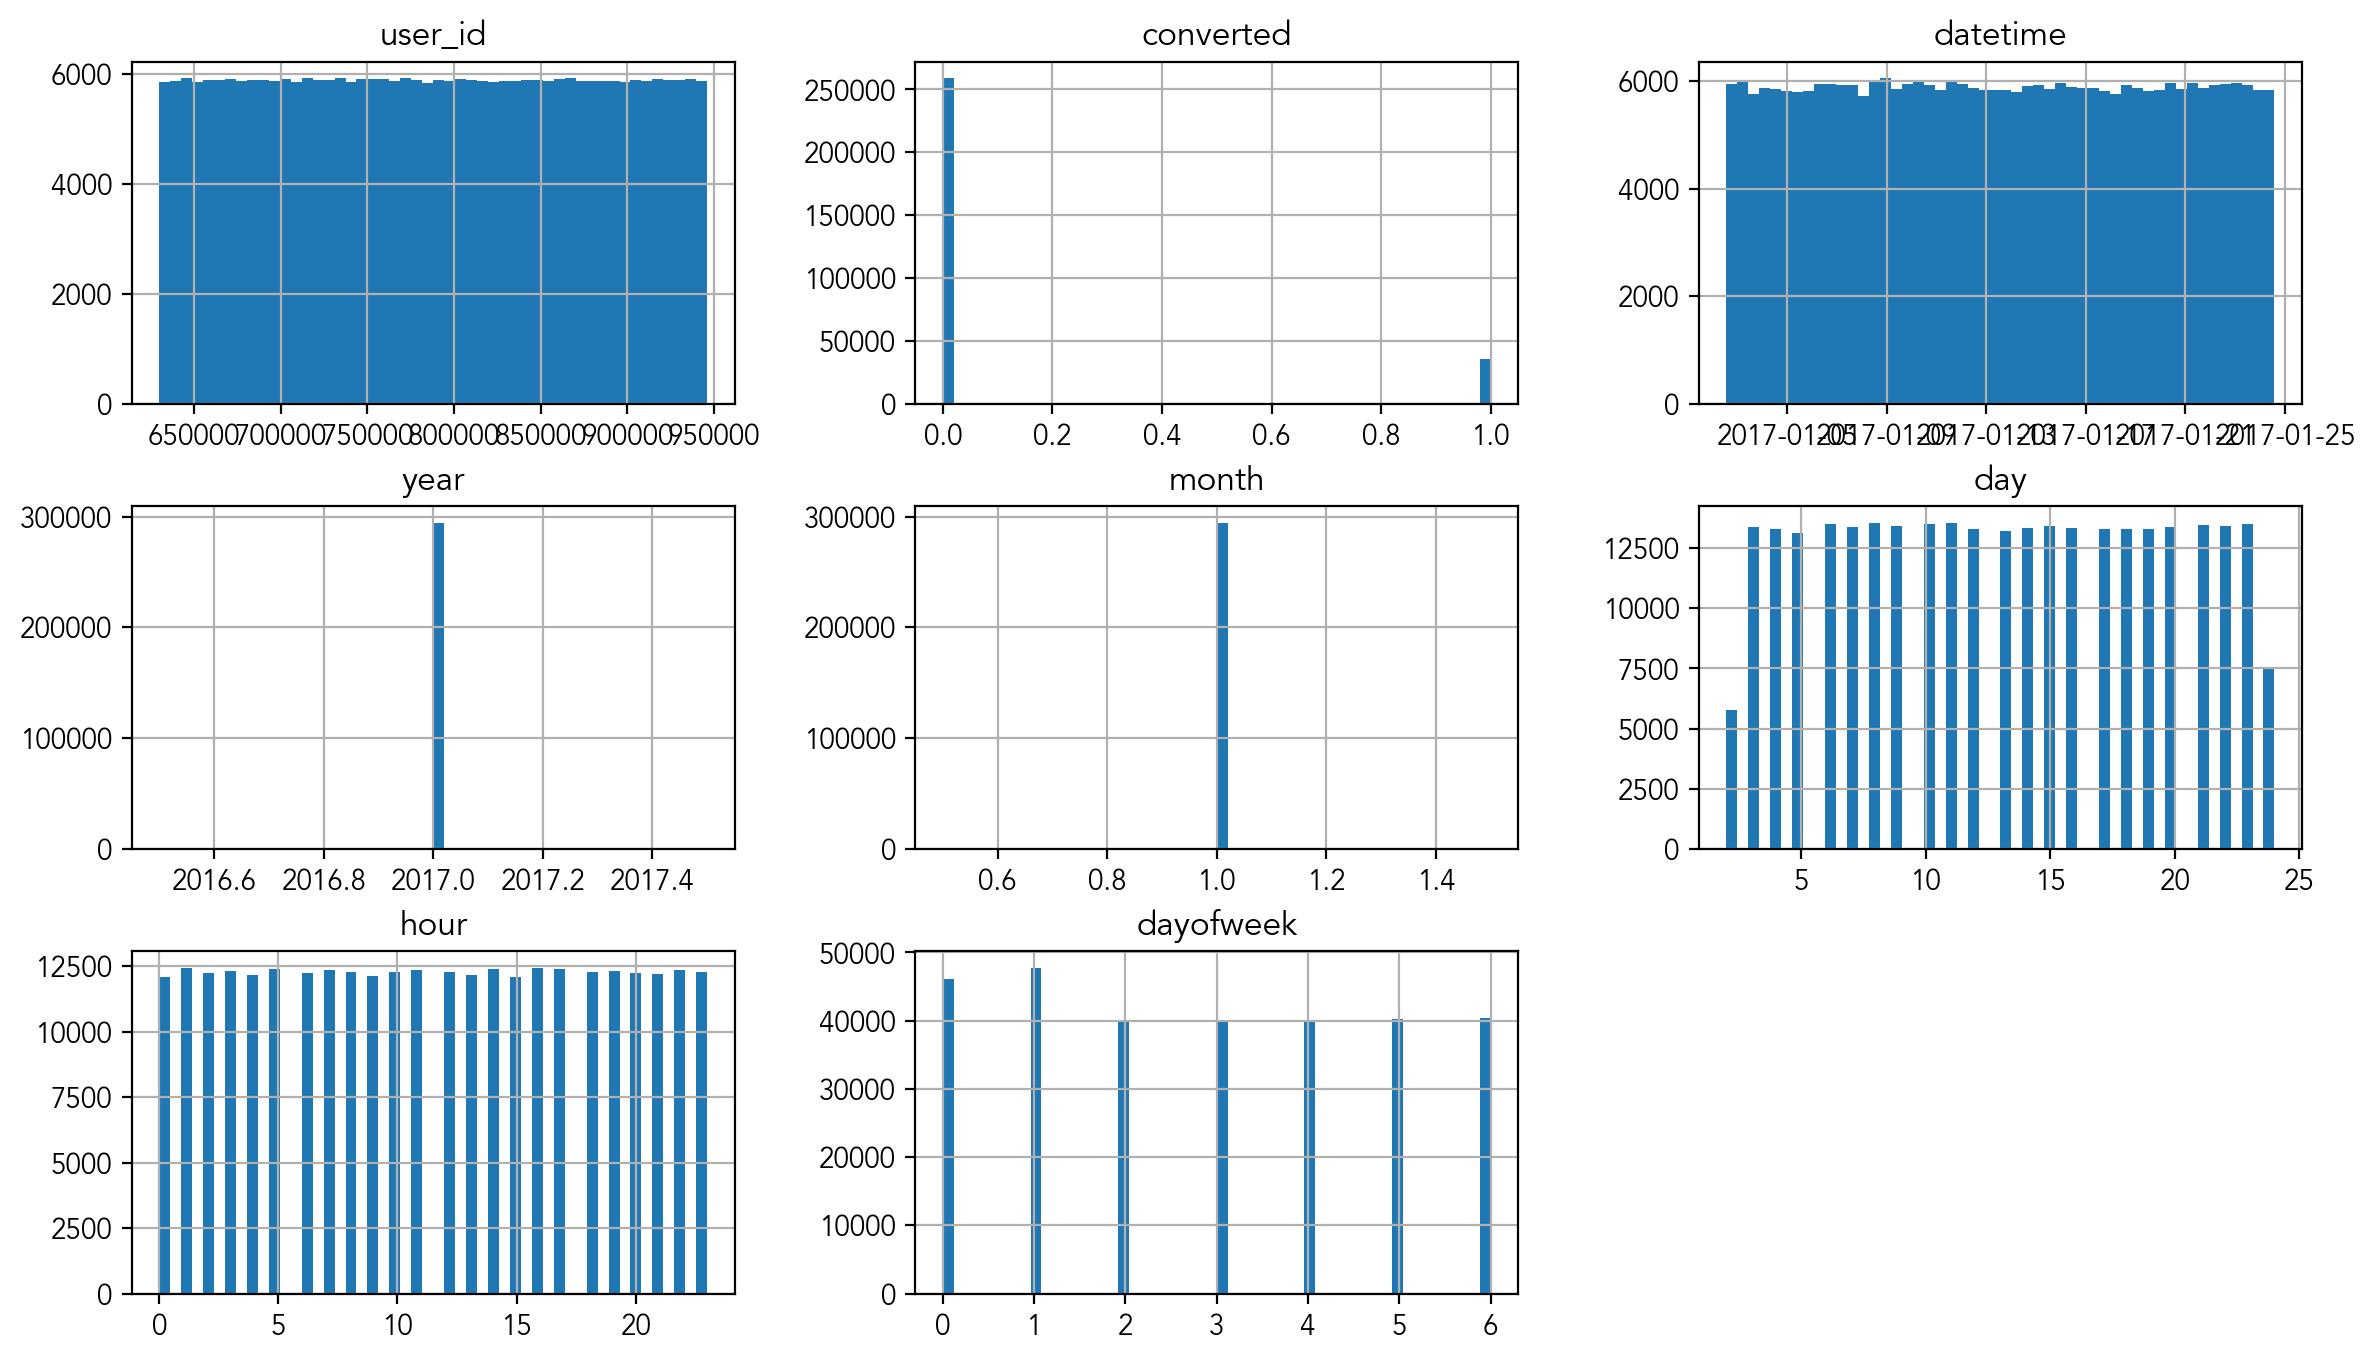

In [23]:
df.hist(bins=50, figsize=(14, 8));
plt.subplots_adjust(hspace = 0.3)

In [24]:
hwd = pd.crosstab(df["hour"], df["dayofweek"])
hwd.columns = [w for w in "월화수목금토일"]
hwd

,월,화,수,목,금,토,일
hour,,,,,,,
0,1667,2205,1612,1726,1637,1647,1581
1,1750,2307,1668,1681,1663,1671,1676
2,1718,2276,1631,1635,1710,1667,1600
3,1697,2230,1663,1663,1692,1668,1680
4,1652,2231,1660,1592,1680,1688,1662
5,1683,2278,1620,1689,1720,1722,1691
6,1602,2236,1673,1661,1662,1693,1688
7,1687,2213,1684,1689,1654,1671,1742
8,1699,2245,1641,1657,1706,1637,1689


/Users/kenny_jung/Library/Python/3.9/lib/python/site-packages/seaborn/utils.py:61: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from current font.
  fig.canvas.draw()
/Users/kenny_jung/Library/Python/3.9/lib/python/site-packages/seaborn/utils.py:61: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from current font.
  fig.canvas.draw()
/Users/kenny_jung/Library/Python/3.9/lib/python/site-packages/seaborn/utils.py:61: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.draw()
/Users/kenny_jung/Library/Python/3.9/lib/python/site-packages/seaborn/utils.py:61: UserWarning: Glyph 47785 (\N{HANGUL SYLLABLE MOG}) missing from current font.
  fig.canvas.draw()
/Users/kenny_jung/Library/Python/3.9/lib/python/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from current font.
  fig.canvas.draw()
/Users/kenny_jung/Library/Python/3.9/lib/python/site-packages/seaborn/utils.py:61: UserWarning

<Axes: ylabel='hour'>

/Users/kenny_jung/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from current font.
  func(*args, **kwargs)
/Users/kenny_jung/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from current font.
  func(*args, **kwargs)
/Users/kenny_jung/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  func(*args, **kwargs)
/Users/kenny_jung/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 47785 (\N{HANGUL SYLLABLE MOG}) missing from current font.
  func(*args, **kwargs)
/Users/kenny_jung/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from current font.
  func(*args, **kwargs)
/Users/kenny_jung/Library/Python/3.9/lib/pyt

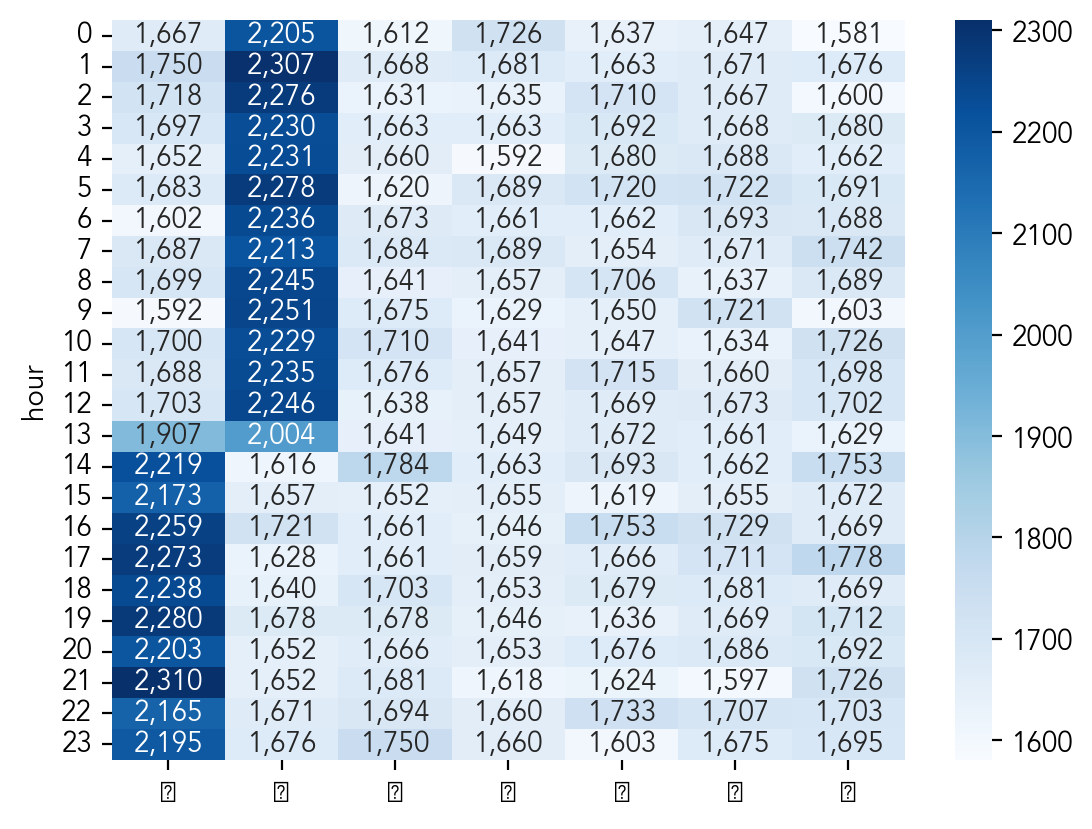

In [14]:
sns.heatmap(hwd, annot=True, fmt=",.0f", cmap="Blues")

<Axes: xlabel='hour'>

/Users/kenny_jung/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from current font.
  func(*args, **kwargs)
/Users/kenny_jung/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from current font.
  func(*args, **kwargs)
/Users/kenny_jung/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  func(*args, **kwargs)
/Users/kenny_jung/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 47785 (\N{HANGUL SYLLABLE MOG}) missing from current font.
  func(*args, **kwargs)
/Users/kenny_jung/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from current font.
  func(*args, **kwargs)
/Users/kenny_jung/Library/Python/3.9/lib/pyt

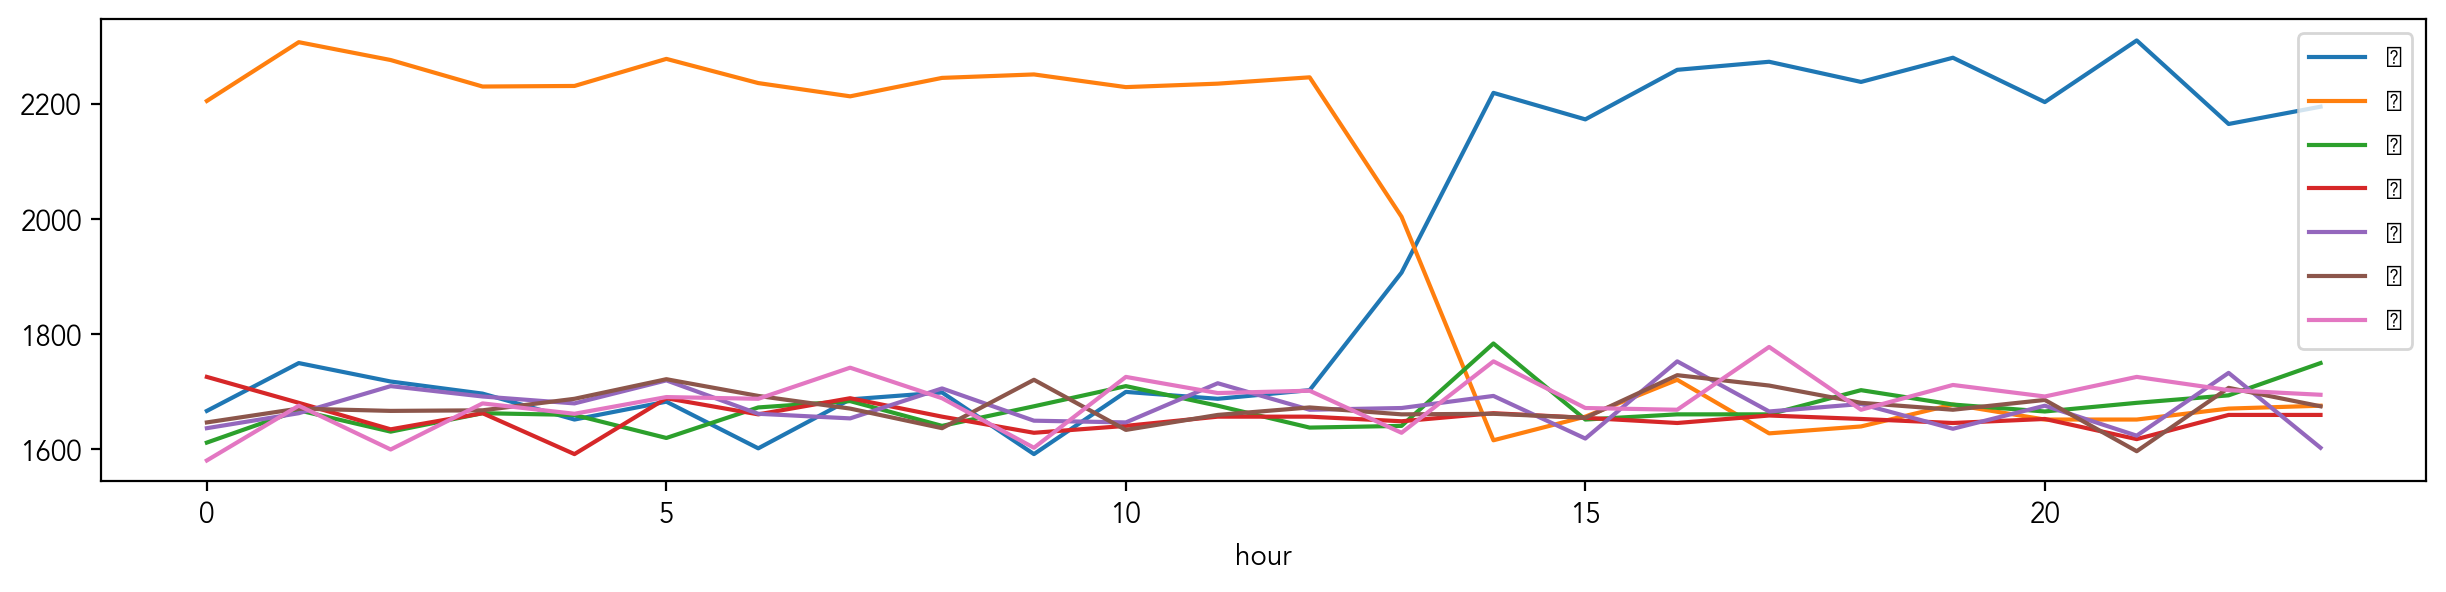

In [25]:
hwd.plot(figsize=(15, 3))

## user_id 당 로그 수 

In [26]:
# session_counts
session_counts = df['user_id'].value_counts()
session_counts.describe()

count    290584.000000
mean          1.013401
std           0.114983
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           2.000000
Name: count, dtype: float64

In [27]:
# session_counts.unique
session_counts.unique()

array([2, 1])

In [28]:
session_counts.value_counts()

count
1    286690
2      3894
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='Count'>

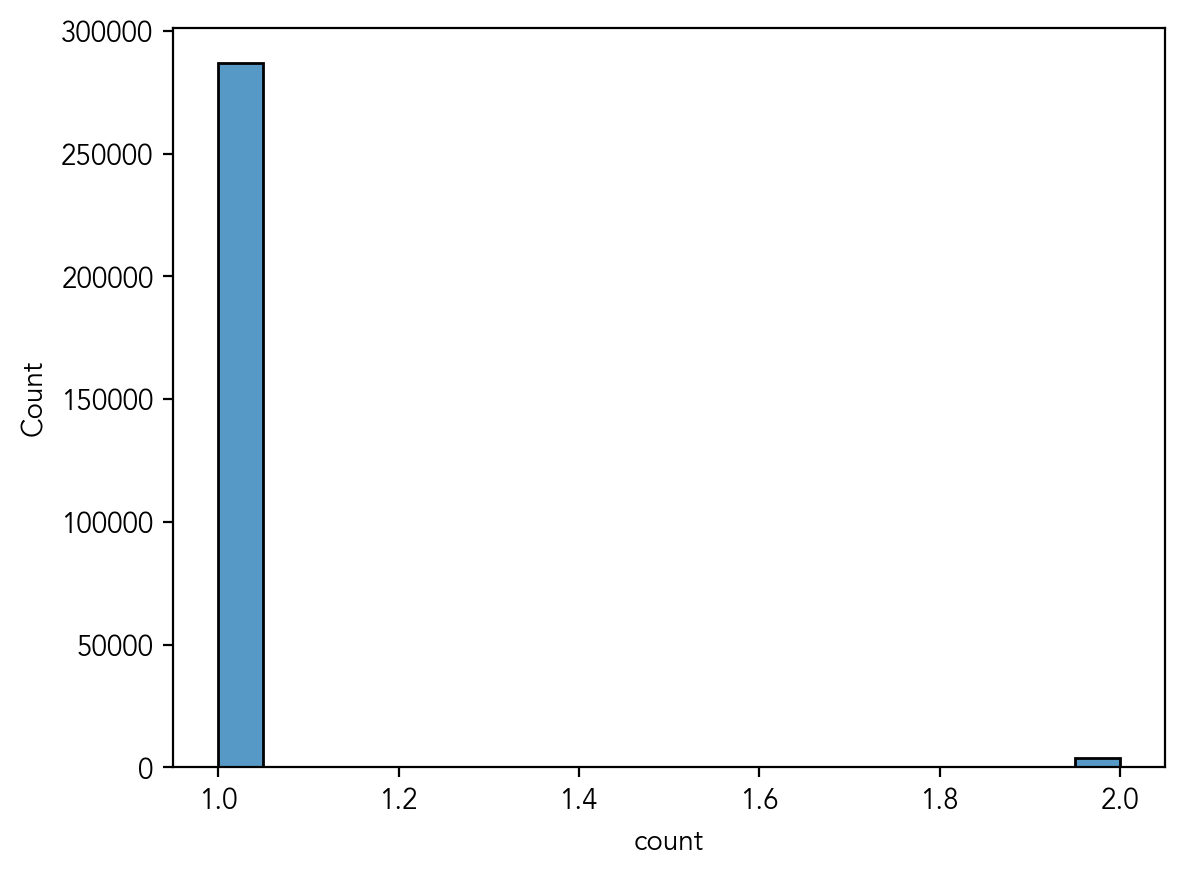

In [29]:
# hist
sns.histplot(session_counts, kde=False)

In [30]:
# multi_users_count
multi_users = session_counts[session_counts > 1]
multi_users_count = multi_users.count()

## landing_page 와 group 의 교차표

In [31]:
multi_users.index

Index([805339, 754884, 722274, 783176, 898232, 899018, 904570, 842042, 881123,
       858720,
       ...
       721188, 902463, 713355, 827417, 655283, 847058, 889392, 664150, 835401,
       736955],
      dtype='int64', name='user_id', length=3894)

In [32]:
df_ab = df[df['user_id'].isin(multi_users.index)].copy() # 깊은 복사???
df_ab.shape

(7788, 12)

Text(0.5, 1.0, 'After removing single-users')

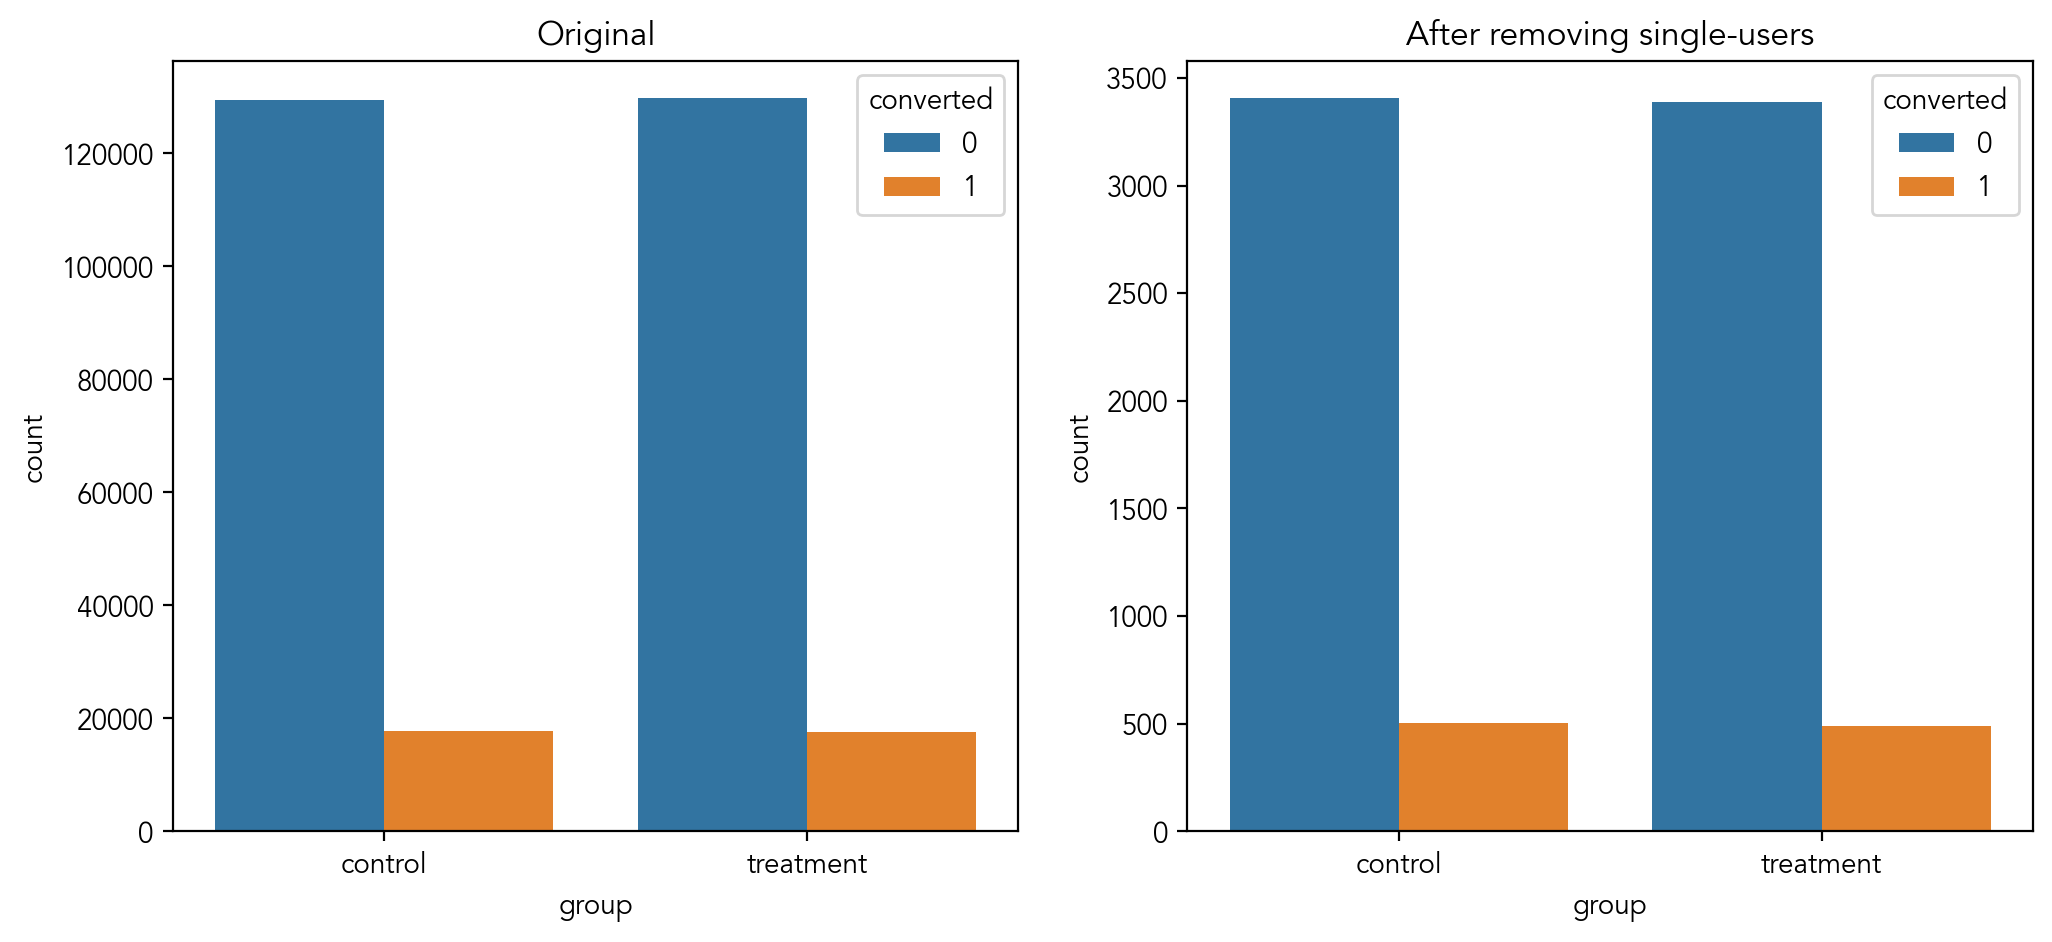

In [33]:
# sns.countplot
f, ax = plt.subplots(1, 2, figsize = (12, 5))
sns.countplot(data = df, x = 'group', hue = 'converted', ax = ax[0])
ax[0].set_title('Original')
sns.countplot(data = df_ab, x = 'group', hue = 'converted', ax = ax[1])
ax[1].set_title('After removing single-users')

Text(0.5, 1.0, 'After removing single-users')

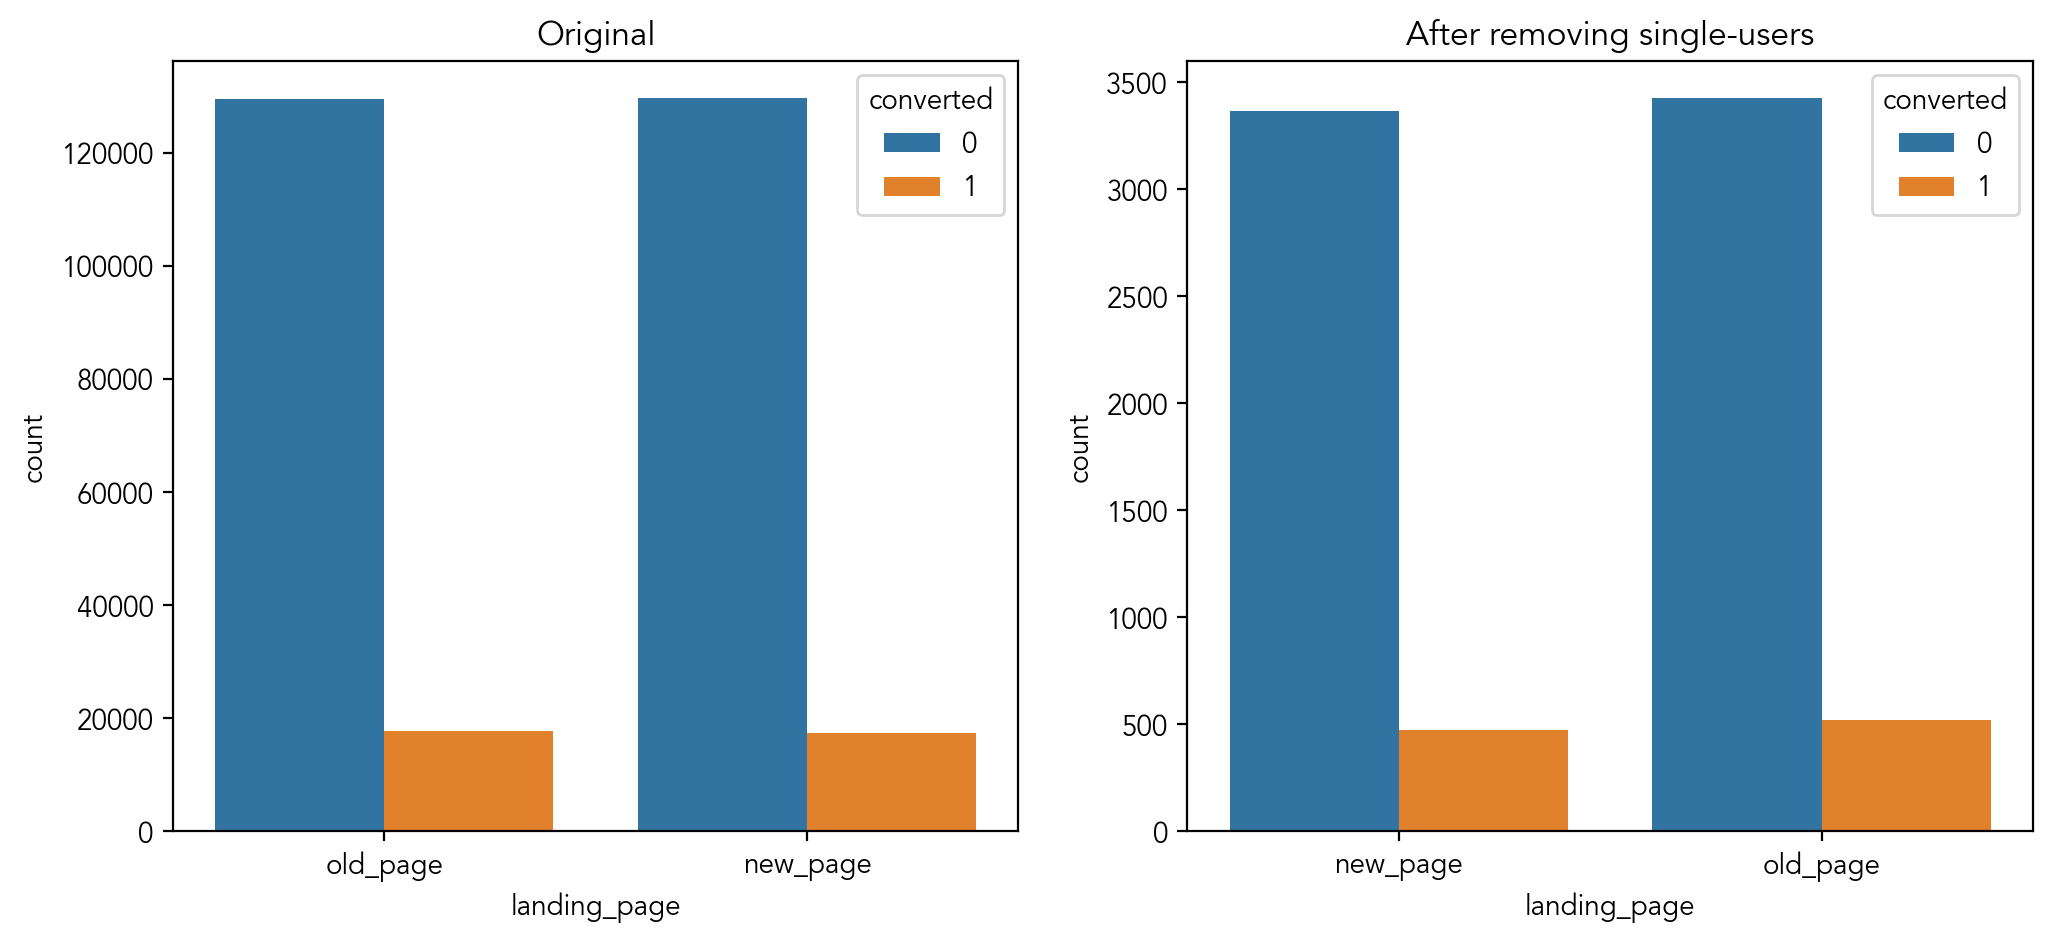

In [34]:
# sns.countplot
f, ax = plt.subplots(1, 2, figsize = (12, 5))
sns.countplot(data = df, x = 'landing_page', hue = 'converted', ax = ax[0])
ax[0].set_title('Original')
sns.countplot(data = df_ab, x = 'landing_page', hue = 'converted', ax = ax[1])
ax[1].set_title('After removing single-users')

Text(0.5, 1.0, 'After removing single-users')

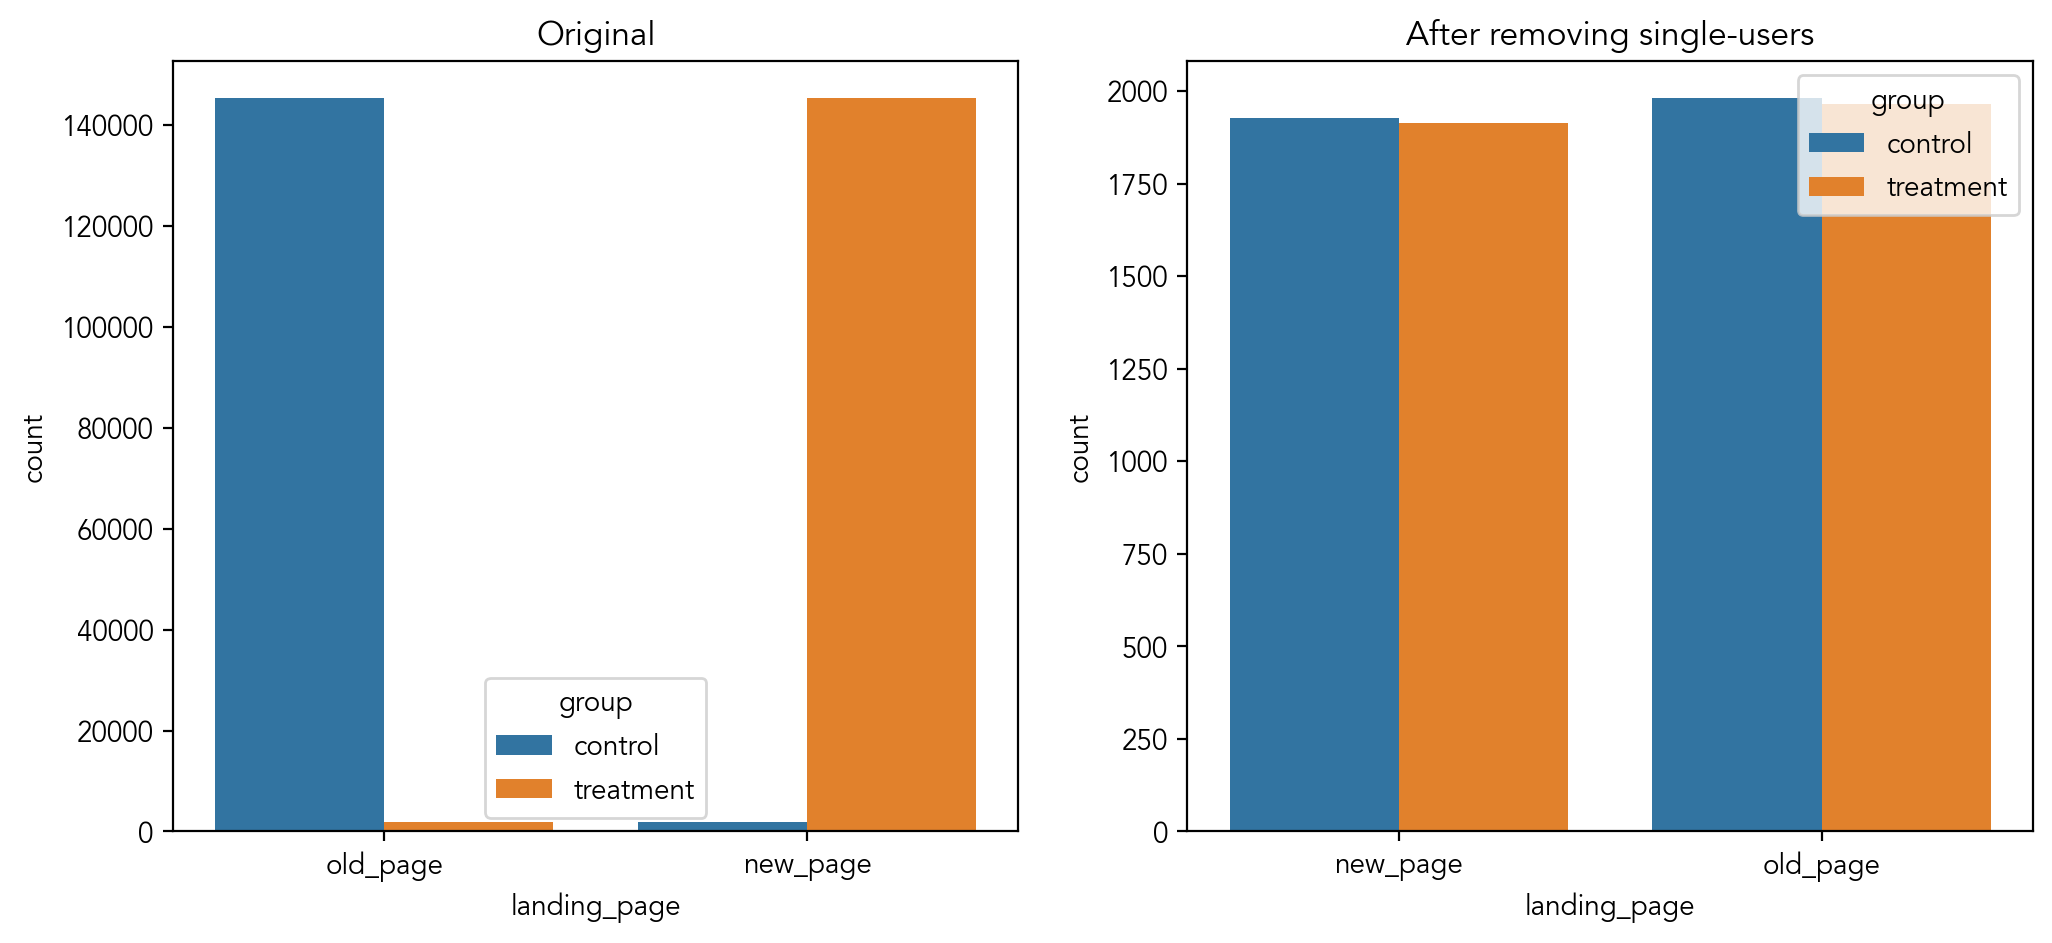

In [35]:
# sns.countplot
f, ax = plt.subplots(1, 2, figsize = (12, 5))
sns.countplot(data = df, x = 'landing_page', hue = 'group', ax = ax[0])
ax[0].set_title('Original')
sns.countplot(data = df_ab, x = 'landing_page', hue = 'group', ax = ax[1])
ax[1].set_title('After removing single-users')

In [36]:
df_ab.head()

,user_id,timestamp,group,landing_page,converted,datetime,year,month,day,hour,minute,dayofweek
22,767017,2017-01-12 22:58:14.991443,control,new_page,0,2017-01-12 22:58:14.991443,2017,1,12,22,22:58:14.991443,3
192,656468,2017-01-18 07:13:29.805052,treatment,new_page,1,2017-01-18 07:13:29.805052,2017,1,18,7,07:13:29.805052,2
226,773693,2017-01-23 18:05:45.167335,control,old_page,1,2017-01-23 18:05:45.167335,2017,1,23,18,18:05:45.167335,0
240,733976,2017-01-11 15:11:16.407599,control,new_page,0,2017-01-11 15:11:16.407599,2017,1,11,15,15:11:16.407599,2
246,704650,2017-01-04 19:10:52.655062,treatment,new_page,0,2017-01-04 19:10:52.655062,2017,1,4,19,19:10:52.655062,2


In [37]:
# pd.crosstab
pd.crosstab(df['landing_page'], df['group'])

group,control,treatment
landing_page,,
new_page,1928,145311
old_page,145274,1965


## 대응표본 t-검정(Paired t-test)과 윌콕슨 부호순위검정(Wilcoxon signed-rank test)


* 대응표본 t-검정
    * 대응표본 t-검정은 변환율과 같은 연속적인 데이터에 대해 두 그룹 간의 평균 차이를 비교할 때 사용됩니다. 
    * 대응표본 t-검정은 두 그룹이 서로 독립적이지 않고, 관련이 있는 경우에 사용됩니다. 
    * 예를 들어, 동일한 사용자가 구 페이지와 신 페이지를 모두 경험했을 때 그들의 변환율을 비교하는 경우입니다. 그러나 제공된 데이터에는 각 사용자가 한 그룹에만 속해 있기 때문에, 이 상황에서는 독립표본 t-검정이 적절할 것입니다.
    * 두 집단 간의 평균 변환율 차이를 비교합니다. 이 경우에는 같은 사용자가 'old_page'와 'new_page'에서의 변환율을 비교하는 것입니다.

* 윌콕슨 부호순위검정
    * 윌콕슨 부호순위검정은 비모수적 방법으로, 데이터가 정규분포를 따르지 않거나 순위 데이터와 같은 비연속적인 경우에 사용됩니다.
    * 윌콕슨 부호순위검정은 두 관련된 그룹 간의 중앙값 차이를 비교할 때 사용됩니다. 이는 데이터가 정규분포를 따르지 않거나, 순위나 범주형 데이터를 다룰 때 유용합니다. 이 경우에도 동일한 사용자가 두 페이지를 모두 경험한 데이터가 필요합니다.
    * 같은 사용자의 'old_page'와 'new_page' 변환율을 비교합니다.

* 검정 과정
    1. 사용자가 두 페이지('old_page'와 'new_page') 모두를 경험했는지 확인
    2. 이러한 사용자들만을 대상으로 데이터를 재구성
    3. 대응표본 t-검정(ttest_rel)과 윌콕슨 부호순위검정(wilcoxon) 수행
    4. 결과 해석

In [ ]:
# conversion_rates
std_p = lambda x: np.std(x, ddof=0)
se_p = lambda x: stats.sem(x, ddof=0)


In [ ]:
# 사용자가 두 페이지 모두에 할당되었는지 확인
# user_group_counts

In [ ]:
# users_with_both_pages 

In [ ]:
# 두 페이지에 모두 할당된 사용자의 수
# num_users_with_both_pages


In [ ]:
# 두 페이지 모두 본 사용자만 포함하기 위해 데이터 필터링
# users_both_pages_data 

In [ ]:
# 각 사용자별로 'old_page'와 'new_page'의 전환 결과를 열로 가지는 피벗 테이블 생성
# users_both_pages_data

In [ ]:
from scipy.stats import ttest_rel, wilcoxon

# Paired t-test
t_test_rel_results

In [ ]:
# Perform a Wilcoxon Signed-Rank test
wilcoxon_results

두 검정 모두에서 'old_page'와 'new_page' 간의 변환율에 통계적으로 유의미한 차이가 없음을 나타냅니다. 이는 새로운 랜딩 페이지(new_page)가 기존 랜딩 페이지(old_page)보다 변환율 측면에서 유의미한 개선을 보이지 않는다는 것을 의미합니다. 그러나 이러한 결과는 다른 요인들(예: 사용자 행동 패턴, 체류 시간 등)을 고려할 필요가 있습니다.

## 전환률 비교


### 비율의 비교

* 교차표 생성
* 카이제곱 독립성 검정
    - 두 그룹 간의 변환율 차이가 통계적으로 유의미한지 평가합니다.

* 피셔의 정확 검정
    - 작은 표본 크기에 대한 카이제곱 검정의 대안으로, 두 그룹 간의 변환율 차이를 정확하게 평가합니다.

* 대응 표본의 비율 비교
    * 맥니마 검정
        - 같은 사용자가 두 조건(예: 'old_page'와 'new_page')에서 얻은 변환 결과 간의 변화를 평가합니다.
        - 맥니마 검정은 사용자별로 두 조건(여기서는 두 페이지)을 모두 경험한 데이터가 필요합니다. 

    * 크래머의 V
        - 교차표에 기반한 카이제곱 검정 결과의 효과 크기를 평가합니다.
        - 크래머의 V는 교차표에서 두 변수 간의 연관성의 정도를 나타내는 척도입니다. 
        - 이 값을 계산하기 위해서는 카이제곱 통계량과 샘플 크기, 그리고 더 작은 차원의 크기(여기서는 2)가 필요합니다. 
        - 크래머의 V 값을 계산하여 두 그룹 간의 연관성을 평가할 수 있습니다.

In [ ]:
# df.groupby("group")["converted"] 의 기술 통계와 분산


In [ ]:
# control_results와 treatment_results는 각각 'control' 그룹과 'treatment' 그룹의 전환 결과입니다.
# control_results
# treatment_results

In [ ]:
# n_con과 n_treat는 각 그룹의 총 관측치 수입니다.
# successes는 각 그룹에서의 전환된(성공한) 경우의 수입니다.
# nobs는 각 그룹의 총 관측치 수의 리스트입니다.
# n_con
# n_treat
# successes
# nobs

In [ ]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

In [ ]:
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

## 교차표
교차표는 'control' 그룹과 'treatment' 그룹의 변환 여부(0 또는 1)를 나타냅니다. 이 표를 통해 두 그룹 간 변환된 사람과 변환되지 않은 사람의 수를 비교할 수 있습니다.

In [ ]:
from scipy.stats import chi2_contingency, fisher_exact
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.metrics import cohen_kappa_score

# 교차표 생성
# contingency_table

### 카이제곱 통계량 (Chi-square statistic)
1. 계산
  \[ $X^2 = \sum \frac{(O_i - E_i)^2}{E_i}$ \]
  여기서 \($O_i$\)는 실제 관측된 빈도, \($E_i$\)는 기대되는 빈도입니다. \($O_i$\)와 \($E_i$\)의 차이를 제곱한 후에 기대되는 빈도로 나누어 모든 범주에 대해 더한 값입니다.

2. 자유도 (Degrees of Freedom)
    - 자유도는 통계적 검정에서 모델이나 표본에서 독립적으로 자유롭게 변동할 수 있는 정도를 나타냅니다. 카이제곱 검정에서는 자유도가 범주의 수와 함께 결정됩니다.

3. 기대되는 빈도 (Expected Frequencies)
    - 기대되는 빈도는 각 범주에서의 기대되는 빈도를 나타냅니다. 이는 전체 데이터셋의 빈도와 각 범주의 비율을 곱하여 계산됩니다.

4. 검정 과정
    - 귀무가설(H0): 실제 관측된 빈도와 기대되는 빈도 간에 유의한 차이가 없다.
    - 대립가설(H1): 실제 관측된 빈도와 기대되는 빈도 간에 유의한 차이가 있다.

5. 카이제곱분포 검정
    - 계산된 카이제곱 통계량은 자유도와 함께 카이제곱분포에서 검정에 사용됩니다.
    - 유의수준(일반적으로 0.05)에서의 임계치를 사용하여 귀무가설을 기각하거나 채택합니다.

6. 해석
    - 유의수준에서 기각된다면, 범주 간에는 통계적으로 유의한 차이가 있다고 판단합니다.
    - 기각되지 않는다면, 범주 간에는 통계적으로 유의한 차이가 없다고 판단합니다.



### 카이제곱 독립성 검정 (Chi-Squared Test of Independence)

* 카이제곱 독립성 검정은 두 범주형 변수 간의 독립성을 통계적으로 검증하는 방법입니다. 이 검정은 두 변수가 서로 관련이 있는지 아니면 독립적인지를 판단하는 데 사용됩니다.

* 방법
    - 두 변수에 대한 교차표(빈도표)를 생성합니다.
    - 교차표에서 기대 빈도와 관찰 빈도를 비교합니다.
    - 카이제곱 통계량을 계산하고, 이를 카이제곱 분포와 비교하여 p-값을 얻습니다.
    - p-값을 사용하여 귀무 가설(두 변수가 독립적이라는 가설)을 검증합니다.

* 예를 들어, 성별과 제품 구매 선호도 간의 관계를 조사하고자 할 때 사용할 수 있습니다. 카이제곱 독립성 검정을 통해 성별이 제품 구매 선호도에 영향을 미치는지 여부를 확인할 수 있습니다.

In [ ]:
# 카이제곱 독립성 검정
chi2, p_chi2, dof, expected = ___________(contingency_table)

In [ ]:
print("\n카이제곱 검정 결과:")
print("Chi-squared: ", chi2)
print("p-value: ", p_chi2)
print("Degrees of freedom: ", dof)
print("Expected frequencies:\n", expected)

### 피셔의 정확 검정 (Fisher's Exact Test)

* 피셔의 정확 검정은 작은 표본 크기를 가진 데이터에서 두 범주형 변수 간의 독립성을 검증하는 데 사용됩니다. 카이제곱 검정과 유사하지만, 표본 크기가 작을 때 더 정확한 결과를 제공합니다.

* 방법
    - 2x2 교차표를 생성합니다.
    - 모든 가능한 표본 분포를 고려하여 귀무 가설 하에서 관찰된 교차표가 나타날 확률을 계산합니다.
    - 이 확률들을 합산하여 p-값을 구합니다.
    - p-값을 사용하여 귀무 가설을 검증합니다.

* 예를 들어, 한 병원에서 두 가지 다른 치료법의 효과를 비교하고자 할 때, 각 치료법에 대해 치료 성공과 실패의 빈도가 작을 때 피셔의 정확 검정을 사용할 수 있습니다. 이 검정은 두 치료법 간의 효과 차이가 우연에 의한 것인지 여부를 평가합니다.

In [ ]:
# 피셔의 정확 검정

oddsratio, p_fisher = ___________(contingency_table)

In [ ]:
print("\n피셔의 정확 검정 결과:")
print("Odds ratio: ", oddsratio)
print("p-value: ", p_fisher)

In [ ]:
# 대응 표본의 비율 비교를 위한 맥니마 검정
# 두 페이지 모두를 경험한 사용자들만 필터링
users_both_pages_data

In [ ]:
# 대응 표본의 비율 비교를 위한 맥니마 검정은 사용자별로 두 조건을 모두 경험한 데이터가 필요
# 이 부분은 데이터가 이에 해당하는지 확인한 후 진행합니다.

In [ ]:
# 교차표 생성
contingency_table = pd.crosstab(df['group'], df['converted'])
contingency_table

In [ ]:
# McNemar 검정 수행을 위한 데이터 생성
# 여기서는 'control' 그룹에서 converted가 0인 경우와 
# 'treatment' 그룹에서 converted가 1인 경우를 조합
df_mcnemar = df[((df['group'] == 'control') & (df['converted'] == 0)) | 
                ((df['group'] == 'treatment') & (df['converted'] == 1))]

# 교차표 생성
contingency_mcnemar = pd.crosstab(df_mcnemar['group'], df_mcnemar['converted'])
contingency_mcnemar

### 맥니마 검정
[statsmodels.stats.contingency\_tables.mcnemar - statsmodels](https://www.statsmodels.org/dev/generated/statsmodels.stats.contingency_tables.mcnemar.html)

In [ ]:
# statsmodels.stats.contingency_tables.mcnemar
from statsmodels.stats.contingency_tables import mcnemar

# 맥니마 검정 수행
# mcnemar(contingency_mcnemar, exact=True, correction=True)
# statistic, p_value = mcnemar(contingency_mcnemar)

# 결과 출력
# print(f'McNemar 검정 통계량: {statistic}, p-값: {p_value}')

McNemar 검정 통계량이 크고 p-값이 0.0으로 나온다면. 이는 귀무가설을 기각하고 대립가설을 채택할 충분한 증거가 있다는 것을 의미합니다. McNemar 검정의 귀무가설은 두 범주형 변수 간에 동질성이 있다는 것이지만, 이 결과는 두 변수 간에 유의한 차이가 있다는 것을 나타냅니다.

따라서 'control' 그룹에서 'converted'가 0인 경우와 'treatment' 그룹에서 'converted'가 1인 경우의 비율이 서로 다르다고 할 수 있습니다.

In [ ]:
# 예시 데이터 생성
data = {
    'user_id': range(1, 11),
    'old_page_converted': [1, 0, 1, 0, 0, 1, 1, 0, 1, 0],
    'new_page_converted': [1, 1, 0, 0, 1, 0, 1, 1, 0, 0]
}
df_example = pd.DataFrame(data)

# 대응하는 샘플의 변화를 나타내는 2x2 교차표 생성
# 'old_page_converted'와 'new_page_converted'의 조합을 카운트
mc_contingency_table = pd.crosstab(df_example['old_page_converted'], df_example['new_page_converted'])

display(mc_contingency_table)
# 맥니마 검정 수행
mcnemar_result = mcnemar(mc_contingency_table)

# 결과 출력
print(mcnemar_result)

### Cramer's V 검정

* Cramer's V(크레이머의 V)는 범주형 변수 간의 연관성을 측정하기 위한 통계적 지표 중 하나로 사용
* 주로 교차표(Contingency Table)의 크기에 따라 크레이머의 V를 계산
* 크레이머의 V는 0부터 1까지의 값을 가지며, 0은 아무런 연관성이 없음을, 1은 완벽한 연관성을 나타냄
* https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V

In [ ]:
# Cramer's V 검정
# Cramer's V는 범주형 변수 간의 관련성을 확인하는 지수
# 크래머의 V 계산
# 1) 교차표의 모든 값의 합(n)을 구합니다.
# 2) 크래머의 V는 np.sqrt(chi2_cramer / (n * (min(contingency_table.shape) - 1))) 공식으로 계산됩니다. 
# 여기서 chi2_cramer는 카이제곱 통계량, 
# n은 전체 관측치 수, 
# min(contingency_table.shape) - 1는 교차표의 최소 차원 수에서 1을 뺀 값입니다.

chi2_cramer, _, _, _ = chi2_contingency(contingency_table)
# n 
# cramer_v

In [ ]:
# 결과 출력
print(f"Cramer's V: {cramer_v}")

Cramer's V는 범주형 변수 간의 관련성을 나타내는 지수이며, 0에 가까울수록 두 변수 간의 연관성이 낮다는 것을 의미합니다. 따라서 이 결과에서는 'group'과 'converted' 간의 강한 연관성이 없다고 볼 수 있습니다.